In [3]:
import sys
import os

local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')

In [4]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import astropy.units as u
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy import stats
import MulensModel as mm
from MulensModel.utils import Utils
import mcmcFit as mcfit

In [5]:
#reading in data and loading it as arrays 

from glob import glob
im_dir = '/Users/adrianhernandez/JPL_2021/ukirt_psf/'
ukirt_file = glob(f"{im_dir}/*P71224*.txt")

#print(ukirt_file[2])

filename = ukirt_file[2][44:64]
ukirt_data_H = np.loadtxt(ukirt_file[0], usecols=range(3)) #H band data 
ukirt_data_K = np.loadtxt(ukirt_file[2], usecols=range(3)) # K band data 
H_data = mm.MulensData(file_name=ukirt_file[0]) #used only for the mulens code 
K_data = mm.MulensData(file_name=ukirt_file[2]) #used only for the mulens code
print(filename)

data = np.concatenate((ukirt_data_H,ukirt_data_K)) # combining both bands
print(len(data))




2019_c2_4_4_H_P71224
645


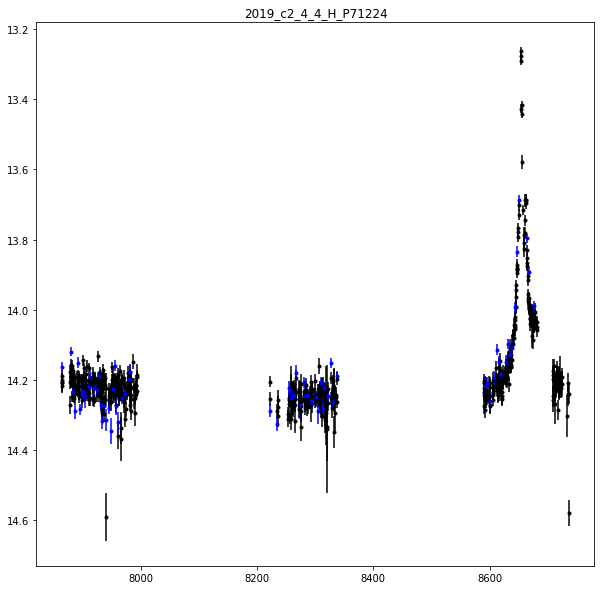

In [6]:
# Look at the data and find the light curve 

# Plot the data
pl.figure(figsize=(10,10))
pl.errorbar(H_data.time - 2450000, H_data.mag, yerr=H_data.err_mag, fmt='.k')
pl.errorbar(K_data.time - 2450000, K_data.mag, yerr=K_data.err_mag, fmt='.b')
pl.title(filename)
pl.gca().invert_yaxis()
pl.show()


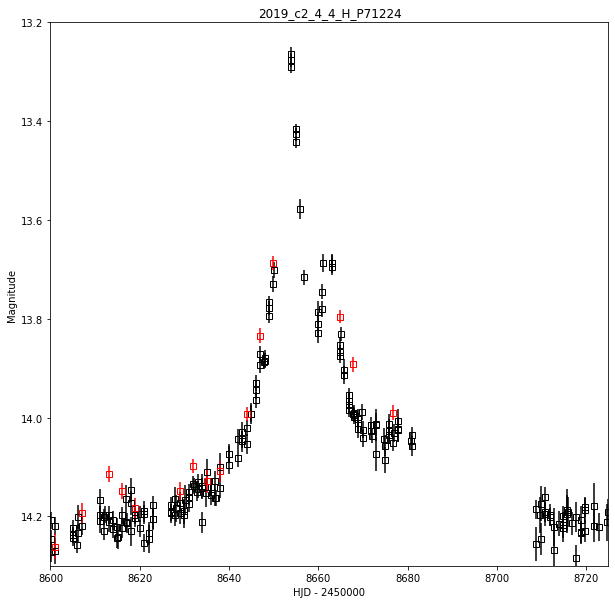

In [7]:
# Zoom in on light curve and find the planetary pertubation if one exits 

pl.figure(figsize=(10,10))
pl.errorbar(H_data.time - 2450000, H_data.mag, yerr=H_data.err_mag, fmt='sk',markerfacecolor='none')
pl.errorbar(K_data.time - 2450000, K_data.mag, yerr=K_data.err_mag, fmt='sr',markerfacecolor='none')
pl.xlim(8600,8725)
pl.ylim(13.2,14.3)
pl.xlabel('HJD - 2450000')
pl.ylabel('Magnitude')
pl.title(filename)
pl.gca().invert_yaxis()
#pl.savefig('2019_c2_4_4_H_P71224.png', format='png', dpi=1200)
pl.show()


In [8]:
# ***Set time range of planetary perturbation (including 2450000).***
(t_planet_start, t_planet_stop) = (2458660.,2458690.)

# ***Set time range of planetary perturbation (including 2450000).***

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [0, 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2459000.]

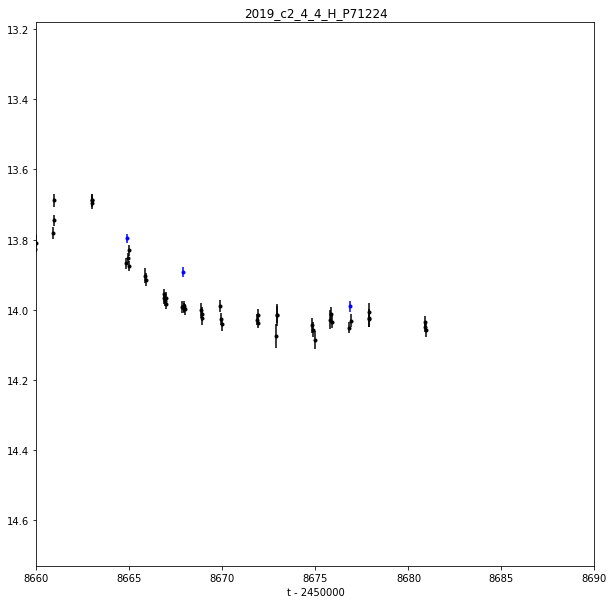

In [9]:
pl.figure(figsize=(10,10))
pl.errorbar(H_data.time - 2450000, H_data.mag, yerr=H_data.err_mag, fmt='.k')
pl.errorbar(K_data.time - 2450000, K_data.mag, yerr=K_data.err_mag, fmt='.b')
pl.xlim(t_planet_start -2450000, t_planet_stop -2450000)
pl.xlabel('t - 2450000')
pl.title(filename)
pl.gca().invert_yaxis()
pl.show()

In [10]:
#create arrays for time, magnitude, and error 
#these arrays conntain both the H & K bands 
time = data[:,0]  
mag = data[:,1]
error = data[:,2]
data_points = len(data)

In [11]:
# Flag data related to the planet
flag_planet = (H_data.time > t_planet_start) & (H_data.time < t_planet_stop) | np.isnan(H_data.err_mag)

# Exclude those data from the fitting (for now)
H_data.bad = flag_planet



In [12]:
time_flag = (H_data.time[np.invert(flag_planet)])
mag_flag = (H_data.mag[np.invert(flag_planet)])
err_flag = (H_data.err_mag[np.invert(flag_planet)])

In [13]:
#Very crude estimates for t_0, u_0, and t_E

#estimate t_0 
index_t_0 = np.argmin(mag)
t0_est = time[index_t_0]

# Estimate u_0
baseline_mag = np.min([mag[0], mag[-1]]) # A crude estimate
A_max =10.**((mag[index_t_0] - baseline_mag) / -2.5)
u0_est = 1. / A_max # True in the high-magnification limit

# Estimate t_E by determining when the light curve is A(t) = 1.3 (i.e. delta_mag = 0.3)
t_1 = np.interp( baseline_mag - 0.3, mag[index_t_0:0:-1], time[index_t_0:0:-1])
tE_est = np.abs((t0_est - t_1) / np.sqrt(1. - u0_est**2))

print(t0_est,u0_est,tE_est)

2458653.97477 0.42657951880159234 7.797184882628055


original PARAMS:  {'u0': 0.42657951880159234, 't0': 8653.974770000204, 'tE': 7.797184882628055, 'Ftot': 14.222, 'fb': 0.99, 'chi2': 1, 'chi2red': 1}
initializing walkers
('OK: smaller range2 for JD init', 8653.974770000204)
running mcmc for ground-based data
 setting the burn in
 doing the final run
(' Acceptance fraction:', 0.6429444444444444)
 not doing the autocorr check.  trouble here!
('FIT RESULT:', '      u0', '=', '      0.0680', '+-', ' 0.00601')
(' | chi offset =', '-59.66')
  0.0
('FIT RESULT:', '      tE', '=', '     28.1733', '+-', ' 1.96941')
(' | chi offset =', '10.35')
  0.0
('FIT RESULT:', '      t0', '=', '   8653.4656', '+-', ' 0.04320')
(' | chi offset =', '-11.79')
  0.0
('FIT RESULT:', '    Ftot', '=', '     14.2272', '+-', ' 0.00039')
(' | chi offset =', '13.34')
  0.0
('FIT RESULT:', '      fb', '=', '      0.1035', '+-', ' 0.00916')
(' | chi offset =', '-96.75')
  0.0
None
bestIndex 15586
 param old,new values: u0 0.06795896651784672 0.06737695069975286
 param 

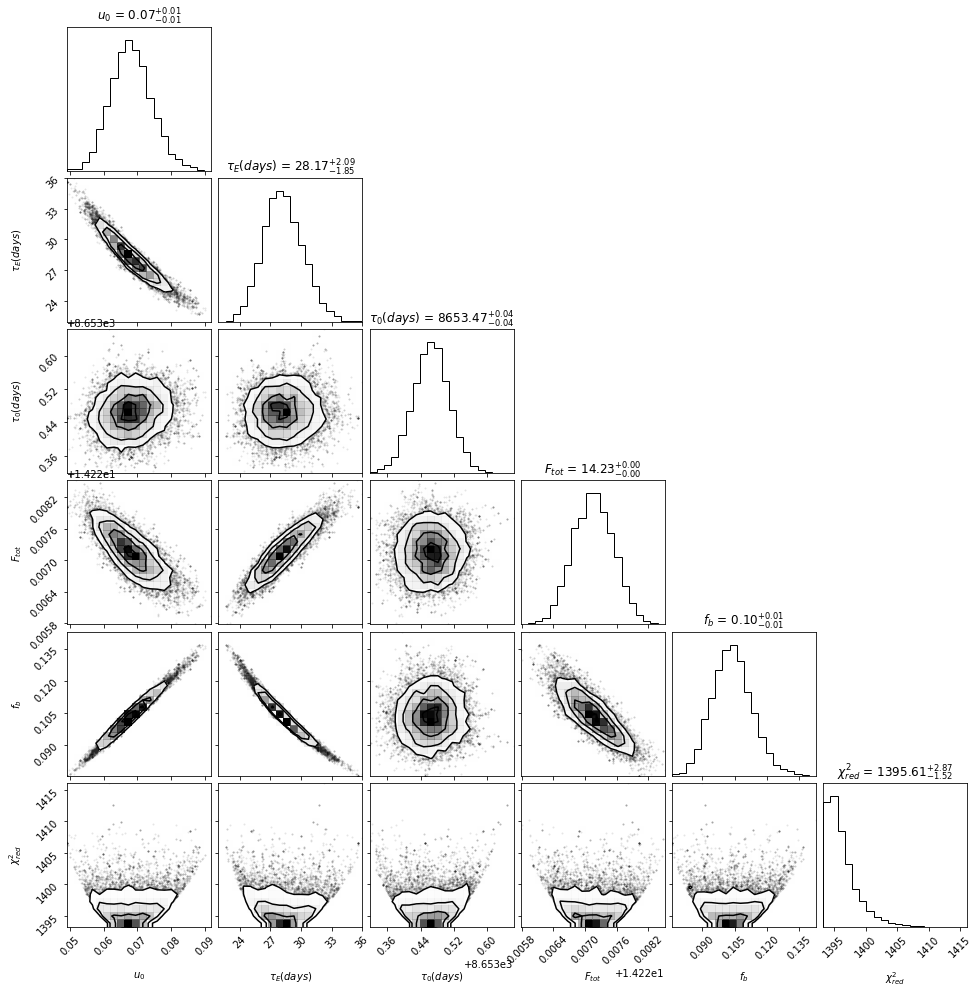

In [14]:
import mcmcFit as mcfit

u0,t0,tE,Ftot,fb,u0err,t0err,tEerr,Ftoterr,fberr = mcfit.mcmcFit(filename,time_flag -2450000, mag_flag, err_flag,u0_est,t0_est-2450000,tE_est)

print('u0, error',u0,u0err)
print('t0, error',t0,t0err)
print('tE, error',tE,tEerr)
print('Ftot, error',Ftot,Ftoterr)
print('Fb, error',fb,fberr)

In [ ]:
print(u0,tE,t0)

In [ ]:
# Look at the PSPL model with MCMC parameters 

pspl_model = mm.Model({'t_0': t0 + 2450000, 'u_0':u0 , 't_E':tE})
pspl_event = mm.Event(datasets=[H_data], model=pspl_model)


print('Initial Guess')
print(pspl_model)

# Plot (excluded data shown as 'X')
pl.figure(figsize=(10,10))
pspl_event.plot_model(t_range = [2457000,2458900],subtract_2450000=True,color='black')
pspl_event.plot_data(show_bad = True, subtract_2450000=True)
pl.xlim(8600,8900)
pl.show()

# point_lens_event.plot_model(t_range = [2457000,2458700],subtract_2450000=True, color='black', zorder=10)
# point_lens_event.plot_data(show_bad=True, subtract_2450000=True)
# pl.xlim(7930,8025)
# pl.show()

In [ ]:
# Un-flag planet data (include it in future fits)
H_data.bad = np.isnan(H_data.err_mag)

In [ ]:
print(pspl_event.model.parameters.t_0)
print(pspl_event.model.parameters.u_0)
print(pspl_event.model.parameters.t_E)

In [ ]:
# Approximate time of the planetary perturbation
t_planet = (t_planet_stop + t_planet_start) / 2.


# Position of the source at the time of the planetary perturbation
tau_planet = ((t_planet - pspl_event.model.parameters.t_0) /
              pspl_event.model.parameters.t_E)
u_planet = np.sqrt(
    (pspl_event.model.parameters.u_0)**2 + tau_planet**2)

# Position of the lens images at the time of the planetary perturbation
# --> Estimate of the planet location
s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)

# Angle between the source trajectory and the binary axis
alpha_planet = np.rad2deg(-np.arctan2(pspl_event.model.parameters.u_0, tau_planet))

print(s_minus)
print(s_plus)
print(alpha_planet)

In [ ]:
# (t_planet_start_new, t_planet_stop_new) = (2458645.,2458685.)

# magnification_methods_new = [0, 'point_source_point_lens', 
#     t_planet_start, 'VBBL', t_planet_stop, 
#     'point_source_point_lens', 2459000.]

In [ ]:
# Look at the planetary moodel with inital guesses
#Try s_plus & s_minus

refine_model = mm.Model({'t_0': 2458654, 
                         'u_0': .03 , 
                         't_E': 50.,
                         'rho': 10**(-2),
                         's': 1.27,
                         'q': 10**(-2),
                         'alpha': -9})
refine_model.set_magnification_methods(magnification_methods)
refine_event = mm.Event(datasets=[H_data,K_data], model=refine_model)

print('chi2: {0}'.format(refine_event.get_chi2()))

print('Planetary Guesses')
print(refine_model)

# Plot (excluded data shown as 'X')
pl.figure(figsize=(10,10))
refine_event.plot_data(subtract_2450000=True, color_list=['blue', 'red'],label_list= ['H_band','K_band'],  s=5)
refine_event.plot_model(t_range=[2457900,2458800], subtract_2450000=True, color='black')

pl.xlim(8600,8725)
pl.show()

pl.figure(figsize=(10,10))
refine_event.plot_data(show_bad=True, subtract_2450000=True)
refine_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.xlim(8655,8685)
pl.show()

In [ ]:
# (t_planet_start_new, t_planet_stop_new) = (2458645.,2458685.)

# magnification_methods_new = [0, 'point_source_point_lens', 
#     t_planet_start, 'VBBL', t_planet_stop, 
#     'point_source_point_lens', 2459000.]

In [ ]:
# # Estimate s (projected separation) of the planet, alpha (angle of source trajectory)

# # Approximate time of the planetary perturbation
# t_planet = (t_planet_stop_new + t_planet_start_new) / 2.


# # Position of the source at the time of the planetary perturbation
# tau_planet = ((t_planet - 2458653.42979) /
#               48.5405)
# u_planet = np.sqrt(
#     (0.034836)**2 + tau_planet**2)

# # Position of the lens images at the time of the planetary perturbation
# # --> Estimate of the planet location
# s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
# s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)

# # Angle between the source trajectory and the binary axis
# alpha_planet = np.rad2deg(-np.arctan2(
#     0.034836, tau_planet))

# print(s_minus)
# print(s_plus)
# print(alpha_planet)


In [ ]:
## np.set_printoptions(threshold=sys.maxsize)

#Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf 
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2(fit_blending = True)

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [ ]:
import numpy as np
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.1
delta_log_q = 0.1
# grid_log_s = np.hstack(
#     (np.arange(
#         np.log10(s_minus) - 0.1, np.log10(s_minus) + 0.1, delta_log_s),
#     np.arange(
#         np.log10(s_plus) - 0.1, np.log10(s_plus) + 0.1, delta_log_s)))
grid_log_s = np.arange(np.log10(.5),np.log10(1.5),delta_log_s)
grid_log_q = np.arange(-5, -1, delta_log_q)

print(a)
print(grid_log_s)
print(grid_log_q)

In [ ]:
print(refine_event.model.parameters.t_0)
print(refine_event.model.parameters.u_0)
print(refine_event.model.parameters.t_E)

In [ ]:
alpha_new = -9

In [ ]:

#Grid fitting is sensitive to PSPL parameters 
# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_new + 180.
        else:
            alpha = alpha_new
            
        # Define the Model and Event
        planet_model = mm.Model({
            't_0': refine_event.model.parameters.t_0, 
            'u_0': refine_event.model.parameters.u_0,
            't_E': refine_event.model.parameters.t_E,
            'rho': 10**(-2),
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets = [H_data,K_data], model=planet_model)
            
        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha.value
        grid[4, i] = planet_event.model.parameters.rho      
        i += 1

In [ ]:
# Identify the best model(s)
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))

In [ ]:
# Plot the grid

n_best = 8 
colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(1):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))
    
    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2., 
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q/ 2., 
            np.max(grid_log_q) / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()

In [ ]:
print(planet_event.model.parameters.t_0)

In [ ]:
def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': planet_event.model.parameters.t_0, 
        'u_0': planet_event.model.parameters.u_0,
        't_E': planet_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1, index],
        'alpha': grid[3, index]})
    model.set_magnification_methods(magnification_methods)
    return model

In [ ]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)

best_fit_event = mm.Event(datasets=[H_data,K_data], model=best_fit_model)
(f_source, f_blend) = best_fit_event.get_ref_fluxes(fit_blending = True)

# # Whole model
# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]
pl.figure(figsize=(10,10))
best_fit_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black')
best_fit_event.plot_data(subtract_2450000=True)
pl.title(filename + ' Grid model ')
pl.savefig(filename + '_grid_model', dpi=100)
pl.show()

# Zoom of planet
# Best model = black
pl.figure(figsize=(10,10))
best_fit_event.plot_model(subtract_2450000=True, color='black',label='best',zorder=10)
best_fit_event.plot_data(subtract_2450000=True, s=5, zorder=10)
pl.xlim(8600,8725)
pl.title(filename + ' grid model zoom')
pl.savefig(filename + '_grid_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
best_fit_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.2,.2)
pl.title(filename + ' grid model residuals')
pl.savefig(filename + '_grid_model_res', dpi=100)
pl.show()

# Other models (color-coding matches grid)
for j, index in enumerate(index_sorted[1:n_best]):
    model = make_grid_model(index)
    pl.figure(figsize=(10,10))
    model.plot_lc( f_source=f_source, f_blend=f_blend,
        subtract_2450000=True, color=colors[j - 1], lw=2)
    best_fit_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
    pl.title('{0} best models'.format(n_best))
    pl.xlim(8640,8685)
    pl.legend(loc='best')

    pl.show()
    print(model)
    

for j, index in enumerate(index_sorted[1:n_best]):
    model.plot_trajectory(color='blue', caustics=True)
    #pl.xlim(-.05,.3)
    #pl.ylim(-.10,.10)    
    pl.show()

In [ ]:
# Refine the n_best minima to get the best-fit solution
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q'] #mcmc

fits = []
for index in index_sorted[:n_best]:
    model = make_grid_model(index)
    event = mm.Event(datasets=[H_data,K_data], model=model)
    print(event.model)
    result = fit_model( 
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

In [ ]:
# Plot the best-fit model and output the parameters

# Extract best fit
chi2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
index_best = np.argmin(chi2)

# Setup the model and event
parameters = {}
for i, parameter in enumerate(parameters_to_fit):
    parameters[parameter] = fit_parameters[index_best][i]
    
final_model = mm.Model(parameters)
final_model.set_magnification_methods(magnification_methods)
final_event = mm.Event(datasets=[H_data,K_data], model=final_model)
print(final_event.model)
print('chi2: {0}'.format(final_event.get_chi2()))

# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]

# # Plot the whole light curve
pl.figure(figsize=(10,10))
final_event.plot_data(subtract_2450000=True)
final_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.title(filename + ' final model ')
pl.savefig(filename + 'final_model', dpi=100)
pl.show()

# Plot zoom of the planet
pl.figure(figsize=(10,10))
final_event.plot_data(subtract_2450000=True)
final_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.xlim(8600,8725)
pl.title(filename + ' final model zoom')
pl.savefig(filename + '_final_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.15,.15)
pl.title(filename + ' final model residuals')
pl.savefig(filename + '_final_model_res', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_trajectory(color='blue', caustics=True)
pl.title(filename + ' final model caustic')
pl.savefig(filename + '_final_model_caustic', dpi=100)
pl.show()

In [ ]:
  2581.07 1.2450 0.00871   -9.42 deg 0.00889

In [ ]:
# Look at the planetary moodel with inital guesses
#Try s_plus & s_minus

diff_model = mm.Model({'t_0': 2458653.50731, 
                         'u_0': 0.041189   , 
                         't_E': 43.3148,
                         'rho': 0.01887,
                         's':  1.35031 ,
                         'q': 0.02642772,
                         'alpha': -10.99199})
diff_model.set_magnification_methods(magnification_methods)
diff_event = mm.Event(datasets=[H_data,K_data], model=diff_model)
(f_source, f_blend) = diff_event.get_ref_fluxes(fit_blending = True)

print('chi2: {0}'.format(diff_event.get_chi2(fit_blending=True)))

print('Final model')
print(diff_model)

# Plot (excluded data shown as 'X')
# pl.figure(figsize=(10,10))
# diff_model.plot_lc(t_range=[2457900,2458800], f_source=f_source, f_blend=f_blend,subtract_2450000=True, lw=2, color = 'blue',label = 'best fit')
# diff_event.plot_data(subtract_2450000=True, color_list=['black', 'red'],label_list= ['H_band','K_band'], s= 7,marker_list = 's',markerfacecolor='none')
# pl.title('blah')
# pl.legend(loc='best',fontsize=15)
# pl.xlim(8550,8740)
# pl.show()

pl.figure(figsize=(10,10))
diff_event.plot_data(subtract_2450000=True, color_list=['black', 'red'],label_list= ['H_band','K_band'], s= 7,marker_list = 's',markerfacecolor='none')
diff_model.plot_model( f_source=f_source, f_blend=f_blend,subtract_2450000=True, lw=2, color = 'blue',label = 'best fit')
pl.xlim(8630,8685)
pl.title('Light Curve')
pl.legend(loc='best',fontsize=15)
pl.savefig('light_curve.png', format='png', dpi=1200)
pl.show()

pl.figure(figsize=(10,10))
diff_event.plot_residuals(show_errorbars=True,subtract_2450000=True,label_list= ['H_band','K_band'],s = 10,markerfacecolor='none')
pl.xlim(8630,8685)
pl.ylim(-.15,.15)
pl.legend(loc='best',fontsize=15)
pl.title('Residuals')
pl.savefig('res.png', format='png', dpi=1200)
pl.show()


pl.figure(figsize=(10,10))
diff_event.plot_trajectory(color='blue', caustics=True)
pl.title('Resonant Caustic Structure')
pl.savefig('Caustic.png', format='png', dpi=1200)
pl.show()



